# Taxi Trajectory Prediction

This notebook is part of the Coursera, IBM Advanced Data Science Capstone Project
Cerated by Engin Cicek, ecicek@gmail.com

Data used in this Capstone Project is found on kaggle website titled as "ECML/PKDD 15: Taxi Trajectory Prediction (I)" 

Dataset can be found at : https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i

---------------------------------------------------------------------------------------------------------------

FEATURE ENGINEERING STAGE:

---------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from math import sqrt
from datetime import datetime

from sklearn import preprocessing, linear_model, metrics

In [2]:
%matplotlib inline

Getting Data

In [3]:
df = pd.read_csv('train2.csv')

I will transform and generate new features from TIMESTAMP column and POLYLINE column. Newly created features (date, time, trip starting and ending locations) will then be used to create additional features like month of the year, day of the week, hour of the day, trip distance, duration etc.

-------------------------------------------------------------------------------------------------------------

New Features to be generated from 'TIMESTAMP' Column :

- 'date_time'   : Date and time value in datetime format

- 'month'       : Month of the Year Value extracted from 'date_time' column (numeric - Integer - 0,1,2, ... ,11)

- 'day_of_week' : Day of the Week Value from 'date_time' column (numeric - Integer - 0 Monday, ... , 6 Sunday)

- 'hour_of_day' : Hour of the Day Value extracted from 'date_time' column (numeric - Integer - 0,1,2, ... ,23) 


In [4]:
t=pd.to_datetime(df['TIMESTAMP'], unit='s')

In [5]:
df['date_time']=t

MONTH OF THE YEAR :

In [6]:
df['month']=[x.month for x in t]

(array([130874., 129872., 138969., 137060., 162106., 153095., 145639.,
        125860., 147513., 153393., 286279.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <a list of 11 Patch objects>)

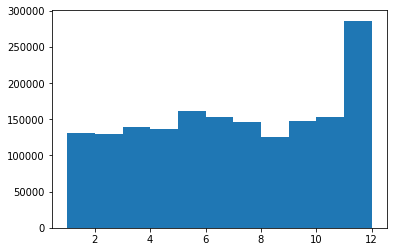

In [7]:
plt.hist(df['month'],bins=11)

In [8]:
df['month'].value_counts(ascending=True)

8     125860
2     129872
1     130874
4     137060
3     138969
11    140024
7     145639
12    146255
9     147513
6     153095
10    153393
5     162106
Name: month, dtype: int64

In [9]:
df['month'].isnull().sum()

0

DAY OF THE WEEK :

In [10]:
df['day_of_week']= [x.dayofweek for x in t]

(array([229948., 234731., 232616., 247025., 277311., 489029.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 6 Patch objects>)

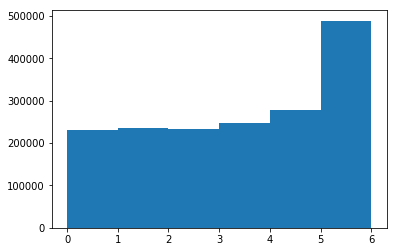

In [11]:
plt.hist(df['day_of_week'],bins=6)

In [12]:
df['day_of_week'].value_counts(ascending=True)

0    229948
6    230395
2    232616
1    234731
3    247025
5    258634
4    277311
Name: day_of_week, dtype: int64

In [13]:
df['day_of_week'].isnull().sum()

0

HOUR OF THE DAY :

In [14]:
df['hour_of_day']=[x.hour for x in t] 

(array([ 49242.,  48663.,  48417.,  55351.,  58514.,  53718.,  53256.,
         69063.,  93032.,  98564.,  91620.,  86002.,  83295.,  88551.,
         92541.,  90972.,  88444.,  84152.,  78369.,  71068.,  67380.,
         59516., 100930.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <a list of 23 Patch objects>)

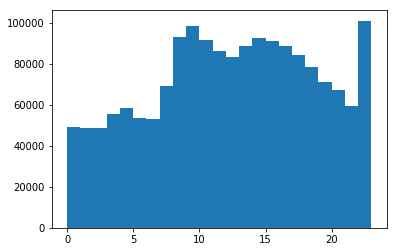

In [15]:
plt.hist(df['hour_of_day'],bins=23)

In [16]:
df['hour_of_day'].value_counts(ascending=True)

2     48417
1     48663
23    48761
0     49242
22    52169
6     53256
5     53718
3     55351
4     58514
21    59516
20    67380
7     69063
19    71068
18    78369
12    83295
17    84152
11    86002
16    88444
13    88551
15    90972
10    91620
14    92541
8     93032
9     98564
Name: hour_of_day, dtype: int64

In [17]:
df['hour_of_day'].isnull().sum()

0

-------------------------------------------------------------------------------------------------------------------------

New Features to be generated from 'POLYLINE' Column :

- 'start_location' : Starting Location [Longitude,Latitude] Coordinates

- 'end_location'   : Ending Location [Longitude, Latitude] Coordinates

- 'dist_travelled' : Total Distance Traveled From Start to the End Location on the Trip (Numeric - Float)

- 'nlegs'          : Number of Intermediate Points Between Start-End (start and end points excluded) (numeric - Integer)

Traveled distance calculation has been calculated not only with starting and ending locations, but also with every coordinates passed during the trip which are also available in POLYLINE column.

Using eucliedean distance calculation between two cooordinates does not give the accurate result because of the earth's shape and distance between longitudes change depending on the location (it is largest at the equator and zero at the poles). Therefore, I used two constants (one for unit latitudes and one for longitude) that are valid for the location of city of Porto relative to the equator by using this web site as a reference. https://www.movable-type.co.uk/scripts/latlong.html.

The calculated distances travelled are verified (with 3 digits accuracy in kilometers) from the same web page referenced above.

In [18]:
# Constants that will be used in calculations

# Distance between 1 degree of latitude and longitude respectiveley (in kilometers)
long_dist_unit=83.92
lat_dist_unit=111.2

# Time_elapse between two consequtive GPS location recordings (in minutes)
te=0.25

In [20]:
# Code Block for extracting coordinates from POLYLINE column and generate new features mentioned above

# Empty lists to be filled for distance, duration of trip, starting location, ending location, average speed
dis=[]
dur=[]
first_loc=[]
last_loc=[]
avg_s=[]

# Looping through every row
for r in range(df.shape[0]):
    x=json.loads(df.loc[r,'POLYLINE'])
    
    k=1
    d=0
    time_elapsed=0
    
    #if no GPS recording
    if len(x)==0:
        loc1=[]
        loc2=[]
    
    #if only one GPS recording (probably only the starting location, but we may not be sure)
    if len(x)==1:
        loc1=x[0]
        loc2=[]
    
    #if there is at least 2 GPS locations are recorded (first and the last will be counted as start-end)
    else: 
        for locs in x:
            if k==1:
                loc1=locs
                temp_loc=locs
            else:
                loc2=locs
                d=d+sqrt(((temp_loc[0]-loc2[0])*long_dist_unit)**2+((temp_loc[1]-loc2[1])*lat_dist_unit)**2)
                temp_loc=locs
                if k==len(x):
                    time_elapsed=time_elapsed+0.1
                else:
                    time_elapsed=time_elapsed+te
                    
            k=k+1
    
    #appending the calculated values to lists
    dis.append(d)
    dur.append(time_elapsed)
    first_loc.append(loc1)
    last_loc.append(loc2)
    
    if time_elapsed>0:
        avg_s.append(d/time_elapsed)
    else:
        avg_s.append(0)

#Converting lists to Series Objects and adding them as new columns to our dataframe
st_loc=pd.Series(first_loc)
df['start_location']=st_loc

end_loc=pd.Series(last_loc)
df['end_location']=end_loc

dist=pd.Series(dis)
df['dist_travelled']=dist

duration=pd.Series(dur)
df['trip_duration']=duration

avg_sp=pd.Series(avg_s)
df['average_speed']=avg_sp

# time_elapsed right before end of trip is added as 6 secs (0.1 mins).
# In fact it is not known (definetely less than 15 secs but more that 0)

START AND END LOCATIONS :

These are newly created columns. We need to check if there is missing value.

DISTANCE TRAVELED :

These are newly created columns. We need to check if there any missing value, outlier etc.

{'boxes': [<matplotlib.lines.Line2D at 0x7f3a2d971d68>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3a2d979748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3a2d903400>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3a2d979f98>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3a2d971eb8>,
  <matplotlib.lines.Line2D at 0x7f3a2d979320>]}

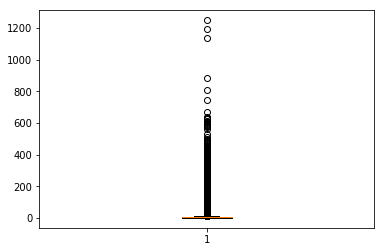

In [38]:
plt.boxplot(df['dist_travelled'])

In [39]:
df['dist_travelled'].describe()

count    1.710670e+06
mean     5.512222e+00
std      7.783789e+00
min      0.000000e+00
25%      2.373003e+00
50%      3.941288e+00
75%      6.549381e+00
max      1.248232e+03
Name: dist_travelled, dtype: float64

In [52]:
near_distance=df.loc[df['trip_duration']==0,['POLYLINE','start_location','end_location','dist_travelled']]

In [ ]:
len(near_distance)

-------------------------------------------------------------------------------------------------------------------

CALL_TYPE Column :



In [9]:
df['CALL_TYPE']=le.transform(df['CALL_TYPE'])

In [10]:
#Checking if we did right label encoding
df['CALL_TYPE'].value_counts(ascending=False)

B    817881
C    528019
A    364770
Name: CALL_TYPE, dtype: int64

------------------------------------------------------------------------------------------------------

ORIGIN_CALL Column :

It contains an unique identifier for each phone number which was used to demand, at least, one service.

It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value;

------------------------------------------------------------------------------------------------------

ORIGIN_STAND :

It contains an unique identifier for each phone number which was used to demand, at least, one service.

It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value.

TAXI ID :

It contains an unique identifier for the taxi driver that performed each trip.

In [ ]:
#df['TIMESTAMP'].drop()